In [2]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
## my functions/classes
from mb_xai import mb_utils
import mb_xai.gut_data as gd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.linear_model import Lasso

# DATA_LOC = '../../../Data/community_optimization/data/'
DATA_LOC = '../../../Data/microbiome_xai/'
# DATA_LOC = '../../Data/microbiome_xai/'

# FLUX_DF_NAME = "micom_medium-fluxes-top5-736_samples.csv"
FLUX_DF_NAME = "micom_medium-fluxes-top50-9285_samples_fd.csv"
SAVE_FIG = True

gut_data = gd.GutData()
gut_data.load_data(
    # FILE_COMM_MODEL='../data/reconstructions/community_5_TOP-vegan.pickle',
    # FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_5_TOP-vegan.pickle',
    # FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_50_TOP.pickle',
    FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_top50_fd.pickle',
    # FILE_GENUS_ASVS = "../data/agp_data/taxon_genus_asvs.csv",
    # FILE_GENUS_ASVS = DATA_LOC + 'agp_data/taxon_genus_asvs.csv',
    FILE_GENUS_ASVS = DATA_LOC + 'agp_data/SILVA_genus_counts_fd.csv',
    # FILE_METADATA = DATA_LOC + "agp_data/mcdonald_agp_metadata.txt",
    FILE_METADATA = DATA_LOC + "agp_data/metadata_biosample_filtered.csv",
    DIR_SIM_DATA = DATA_LOC + "micom-sim-data/"  # "../data/micom-sim-data/",
)
### Load flux dataframe
X_flux = pd.read_csv(gut_data.dir_sim_data+FLUX_DF_NAME,index_col=0, low_memory=False)
X_flux.index = X_flux.index.astype(str)

Fixed EX_tDHNACOA(e)


In [82]:
# SAVE_ID = "maxmin"#"stdscale"
# SAVE_ID = "foodmetabs"
# SAVE_ID = "stdscale"
# SAVE_ID = "PARALLEL"
# SAVE_ID = "PARALLEL_std_noparams"
SAVE_ID = "PARALLEL_std-4_noparams_5_75"

# input_type_aucs_long = pd.read_csv(gut_data.dir_sim_data+'ml_performance.csv', index_col=0)
# imp_feat_abundance_pheno_df = pd.read_csv(gut_data.dir_sim_data+'imp_feat_abundance.csv', index_col=0)
# imp_feat_flux_pheno_df = pd.read_csv(gut_data.dir_sim_data+'imp_feat_flux.csv', index_col=0)
# flux_pheno_direct_df = pd.read_csv(gut_data.dir_sim_data+'imp_flux_direction.csv', index_col=0)

input_type_aucs_long = pd.read_csv(gut_data.dir_sim_data+'ml_performance_%s_fd.csv'%(SAVE_ID), index_col=0)
imp_feat_abundance_pheno_df = pd.read_csv(gut_data.dir_sim_data+'imp_feat_abundance_%s_fd.csv'%(SAVE_ID), index_col=0)
flux_pheno_direct_df = pd.read_csv(gut_data.dir_sim_data+'imp_flux_direction_%s_fd.csv'%(SAVE_ID), index_col=0)
imp_feat_flux_pheno_df = pd.read_csv(gut_data.dir_sim_data+'imp_feat_flux_%s_fd.csv'%(SAVE_ID), index_col=0)
## load food matrix
food_matrix_df = pd.read_csv(DATA_LOC+'tables/food_matrix_df.csv',index_col=0)
# food_matrix_df = pd.read_csv(DATA_LOC+'tables/food_matrix_df_true.csv',index_col=0)
food_matrix_df.drop(["salcn[e]"], inplace=True)

In [83]:
## Negative means it's consumed and positive means it's leaving the system
X_flux_consumed = X_flux[X_flux.columns[X_flux.mean()<0]].copy()
X_flux_consumed_cols = [x.replace("EX_", "").replace("_m__medium", "[e]") for x in X_flux_consumed.columns]
len(X_flux_consumed_cols)

464

In [4]:
imp_feat_flux_pheno_df["vegan_flux"][imp_feat_flux_pheno_df["vegan_flux"].notnull()].sort_values()

EX_fuc_L_m__medium     -2.373709
EX_xyluglc_m__medium   -2.239058
EX_indlac_m__medium    -1.435429
EX_tma_m__medium       -0.827905
EX_gncore1_m__medium   -0.692476
                          ...   
EX_gsn_m__medium        0.751712
EX_ddca_m__medium       0.849221
EX_f1a_m__medium        0.945300
EX_xylt_m__medium       1.193107
EX_ind3ppa_m__medium    2.110458
Name: vegan_flux, Length: 244, dtype: float64

In [90]:
bool_concentrations = True # True
bool_direct_flux = True # False whether to use orig flux df or direction corrected one...
bool_consumption = True
## convert medium flux id to metabolite id used in food matrix

if bool_direct_flux==False:
    imp_feat_flux_pheno_df["id"] = imp_feat_flux_pheno_df.index.map(lambda x: x.replace("EX_", "").replace("_m__medium", "[e]"))
    flux_id_pheno_direct_df = imp_feat_flux_pheno_df.set_index("id")
else:
    flux_pheno_direct_df["id"] = flux_pheno_direct_df.index.map(lambda x: x.replace("EX_", "").replace("_m__medium", "[e]"))
    flux_id_pheno_direct_df = flux_pheno_direct_df.set_index("id")
    
if bool_consumption == True:
    shared_consumed_metabs = list(set(flux_id_pheno_direct_df.index).intersection(set(X_flux_consumed_cols)))
    flux_id_pheno_direct_df = flux_id_pheno_direct_df.loc[shared_consumed_metabs].copy()

flux_id_pheno_direct_df.fillna(0, inplace=True)

## binarize the matrix so 0 describes absence of chemical and 1 describes presence
food_bool_matrix_df = food_matrix_df.copy()
if bool_concentrations==False:
    food_bool_matrix_df[food_bool_matrix_df>0] = 1
food_bool_matrix_df.fillna(0, inplace=True)

## how many important chemicals are found in food matrix?
metab_overlap = list(set(flux_id_pheno_direct_df.index).intersection(set(food_bool_matrix_df.index)))
print(len(metab_overlap))

90


Try compressed sensing

In [67]:
flux_id_pheno_direct_df.loc[metab_overlap]["vegan_flux"].hist()

KeyError: 'vegan_flux'

<AxesSubplot:>

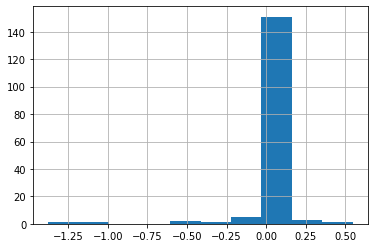

In [79]:
flux_id_pheno_direct_df.loc[metab_overlap]["ibd_flux"].hist()

In [56]:
y_df["vegan_flux"][y_df["vegan_flux"]!=0].shape

(105,)

In [41]:
y_df["vegan_flux"].sort_values()

id
dad_2[e]     -0.153463
asn_L[e]     -0.127513
12ppd_S[e]   -0.127190
glypro[e]    -0.088654
thymd[e]     -0.079735
                ...   
gthox[e]      0.252107
tre[e]        0.268506
gsn[e]        0.751712
ddca[e]       0.849221
xylt[e]       1.193107
Name: vegan_flux, Length: 107, dtype: float64

In [40]:
y_df["flux_vegan"].sort_values()

KeyError: 'flux_vegan'

Non-zero feats (54,)


/home/eskavvas/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5547858474599882, tolerance: 0.0008709131602093013
  model = cd_fast.enet_coordinate_descent(


Non-zero feats (57,)


/home/eskavvas/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02026944591892816, tolerance: 2.7531581894222986e-05
  model = cd_fast.enet_coordinate_descent(


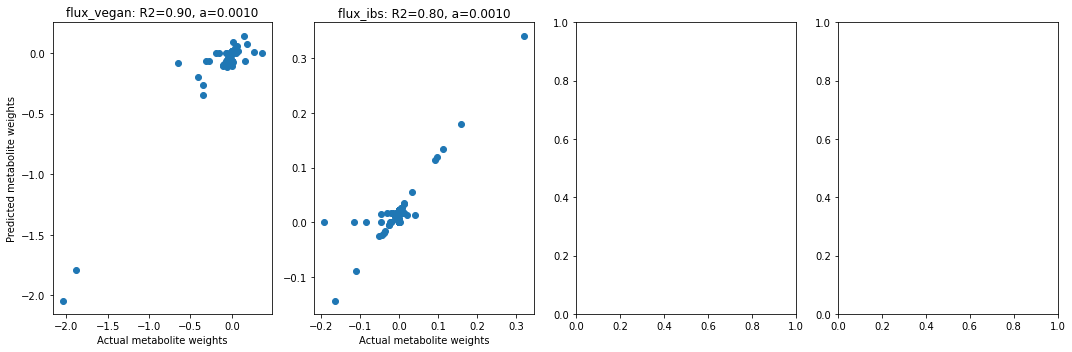

In [91]:
food_signal_df = pd.DataFrame()

y_df = flux_id_pheno_direct_df.loc[metab_overlap].copy()
A_df = food_bool_matrix_df.loc[metab_overlap].copy()

# pheno_id = "vegan_flux"#"ibs_flux"#"vegan_flux"
# lasso_alpha = 1e-3
SAVE_FIG =False
SAVE_ID_ALPHA=3
lasso_alpha = 10**(-SAVE_ID_ALPHA)
f, ax = plt.subplots(1, len(y_df.columns), figsize=(15, 5)) # 5 works well for n_feats=10
for i, pheno_id in enumerate(y_df.columns[:2]):
    print("Non-zero feats",y_df[pheno_id][y_df[pheno_id]!=0].shape)
# for pheno_id in y_df.columns:
    lasso = Lasso(alpha=lasso_alpha ,max_iter=1e5)
    lasso.fit(A_df,y_df[pheno_id])
    score_val = lasso.score(A_df,y_df[pheno_id])
    # print("score:",score_val)

    y_pred = A_df.dot(lasso.coef_)
    # plt.scatter(y_df[pheno_id], y_pred)
    ax[i].scatter(y_df[pheno_id], y_pred)
    ax[i].set_title("%s: R2=%.2f, a=%.4f"%(pheno_id, score_val,lasso_alpha))
    ax[i].set_xlabel("Actual metabolite weights")
    if i==0:
        ax[i].set_ylabel("Predicted metabolite weights")

    x_pred_signal = pd.Series(lasso.coef_, index=A_df.columns)
    # x_pred_signal.sort_values()
    x_pred_signal.name = pheno_id
    food_signal_df = pd.concat([food_signal_df, x_pred_signal],axis=1)
    
f.tight_layout()
if SAVE_FIG == True:
    # f.tight_layout()
    f.savefig(gut_data.dir_sim_data+"figures/"+"food_lasso_scatter_fd_%s_conc-%s_fluxdirect-%s_%s.svg"%(str(SAVE_ID_ALPHA), str(bool_concentrations), str(bool_direct_flux), SAVE_ID))
    f.savefig(gut_data.dir_sim_data+"figures/"+"food_lasso_scatter_fd_%s_conc-%s_fluxdirect-%s_%s.png"%(str(SAVE_ID_ALPHA), str(bool_concentrations), str(bool_direct_flux), SAVE_ID))

In [73]:
food_signal_df["vegan_flux"].sort_values()

KeyError: 'vegan_flux'

Best run is **ML of all metabs, stdscale, no direct correction, all metabs in food matrix, quantification, alpha=1e-2**

Using "stdscale" save id, best is quantification, no direct correlation, alpha=1e-2. Gives meats and milk 

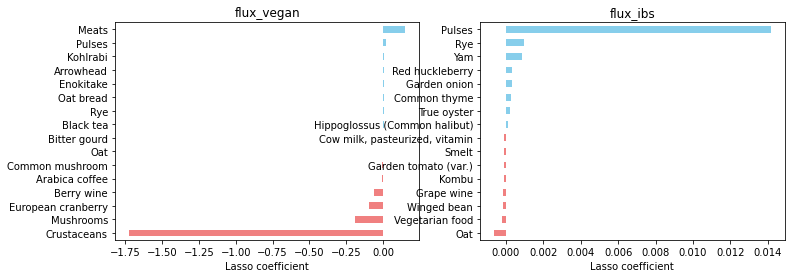

In [92]:
n_feats=8
input_df = food_signal_df.copy()
input_df.index = input_df.index.map(lambda x: x[:30] if len(x) > 25 else x)
f, ax = plt.subplots(1, len(input_df.columns), figsize=(12, n_feats/2)) # 5 works well for n_feats=10
# SAVE_ID="a3"
for i, col in enumerate(input_df.columns):
    top_pos_df = input_df[col].sort_values(ascending=False)[:n_feats][::-1]
    top_neg_df = input_df[col].sort_values(ascending=True)[:n_feats][::-1]
    top_df = pd.DataFrame(pd.concat([top_pos_df, top_neg_df]))
    top_df['positive'] = top_df[col] > 0
    top_df = top_df.sort_values(by=col,ascending=False)[::-1]
    top_df[col].plot(
        kind="barh", color=top_df.positive.map({True: 'skyblue', False: 'lightcoral'}), ax=ax[i])
    # abs(input_df)[col].sort_values(ascending=False)[:5][::-1].plot(kind="barh", ax=ax[i])
    ax[i].set_xlabel("Lasso coefficient")
    ax[i].set_title("%s"%(col))

if SAVE_FIG == True:
    f.tight_layout()
    f.savefig(gut_data.dir_sim_data+"figures/"+"foods_features_%s_barh_fd_conc-%s_fluxdirect-%s_%s.png"%(str(SAVE_ID_ALPHA), str(bool_concentrations), str(bool_direct_flux),SAVE_ID))
    f.savefig(gut_data.dir_sim_data+"figures/"+"foods_features_%s_barh_fd_conc-%s_fluxdirect-%s_%s.svg"%(str(SAVE_ID_ALPHA), str(bool_concentrations), str(bool_direct_flux),SAVE_ID))

In [302]:
y_df["vegan_flux"].sort_values()

id
isobut[e]   -13.276162
glyc[e]      -6.055749
cbl1[e]      -5.853424
pect[e]      -5.602816
srtn[e]      -3.565318
               ...    
galur[e]      6.151234
etha[e]       6.970836
meoh[e]       6.998134
arbt[e]       8.872101
met_L[e]     10.362752
Name: vegan_flux, Length: 147, dtype: float64

In [149]:
x_pred_signal.sort_values()[-10:]

Shea tree                 0.364419
Milk and milk products    0.384757
Japanese pumpkin          0.390908
Root vegetables           0.400703
Nuts                      0.401089
Milk (Cow)                0.522612
Pepper (C. frutescens)    0.583445
Cabbage                   0.599262
Olive                     0.776163
Arabica coffee            1.054733
dtype: float64

In [83]:
y_df[pheno_id].sort_values()

id
asn_L[e]     -0.041426
sucr[e]      -0.036106
pcresol[e]   -0.006862
bz[e]        -0.004775
isocapr[e]   -0.004115
                ...   
glc_D[e]      0.538214
ptrc[e]       1.102686
met_L[e]      1.292175
gcald[e]      1.919387
cgly[e]       3.662378
Name: vegan_flux, Length: 102, dtype: float64